In [1]:
### 导入必要的库
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

from wordcloud import WordCloud


In [2]:
### 读入观察数据
data = pd.read_csv('./spam.csv', encoding='ISO-8859-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
pd.set_option('display.max_colwidth',None)
### 将不需要的列删除，并将列开头重新命名
data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
data.rename(columns={'v1':'label','v2':'text'},inplace=True)
### 数据总量
print('The dataset has {} rows and {} columns.'.format(data.shape[0],data.shape[1]))

The dataset has 5572 rows and 2 columns.


In [4]:
### 数据无缺失
data.isna().sum()

label    0
text     0
dtype: int64

In [5]:
### 查重
data.duplicated().sum()

403

In [7]:
### 去重
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

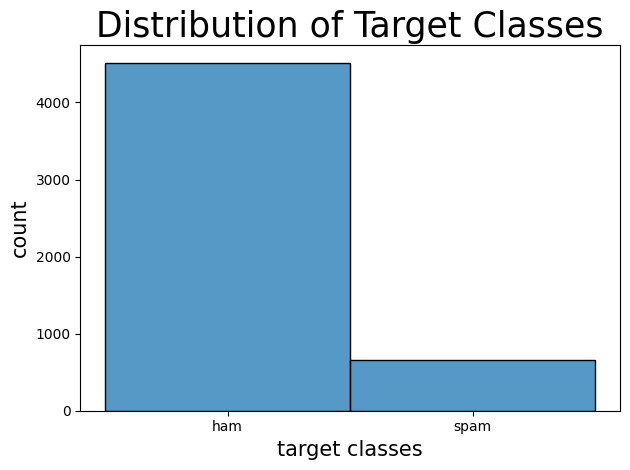

In [8]:
## 看一下数据分布直方图
sns.histplot(data=data,x='label')
plt.title('Distribution of Target Classes',fontsize=25)
plt.xlabel('target classes',fontsize=15)
plt.ylabel('count',fontsize=15)
plt.tight_layout()

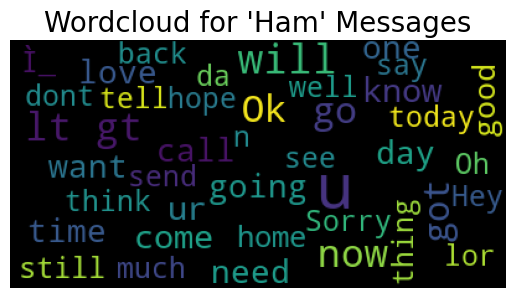

In [9]:
### 检测正常邮件中出现最多的词
text = ' '.join(data[data['label']=='ham']['text'])
wordcloud = WordCloud(max_font_size=50,max_words=40).generate(text)
### 显示
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Wordcloud for 'Ham' Messages",fontsize=20)
plt.show()

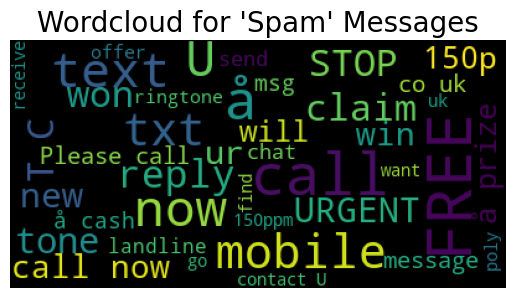

In [10]:
### 检测垃圾邮件中出现最多的词
text = ' '.join(data[data['label']=='spam']['text'])
wordcloud = WordCloud(max_font_size=50,max_words=40).generate(text)

### 显示
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Wordcloud for 'Spam' Messages",fontsize=20)
plt.show()

In [14]:
X = data['text']
y = data['label']
### 划分训练集测试集
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

X_train.count()

3618

In [15]:
def get_test_scores(model_name:str,preds,y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy  = accuracy_score(y_test_data,preds)
    precision = precision_score(y_test_data,preds,average='macro')
    recall    = recall_score(y_test_data,preds,average='macro')
    f1        = f1_score(y_test_data,preds,average='macro')

    table = pd.DataFrame({'model': [model_name],'precision': [precision],'recall': [recall],
                          'F1': [f1],'accuracy': [accuracy]})

    return table 

In [16]:
### 提取文本特征
featurizer = CountVectorizer(decode_error='ignore')  # The option "decode_error='ignore'" is set to take care of the wrongly decoded characters
### 提取特征
X_train2 = featurizer.fit_transform(X_train)
X_test2 = featurizer.transform(X_test)

In [17]:
### 贝叶斯
MNB = MultinomialNB()
MNB.fit(X_train2,y_train)

MNB_train_preds = MNB.predict(X_train2)
MNB_train_results = get_test_scores('MNB (train)',MNB_train_preds,y_train)

MNB_test_preds = MNB.predict(X_test2)
MNB_test_results = get_test_scores('MNB (test)',MNB_test_preds,y_test)

MNB_results = pd.concat([MNB_train_results,MNB_test_results],axis=0)
MNB_results

,model,precision,recall,F1,accuracy
0,MNB (train),0.986750,0.978957,0.982810,0.992814
0,MNB (test),0.980801,0.954940,0.967347,0.984526


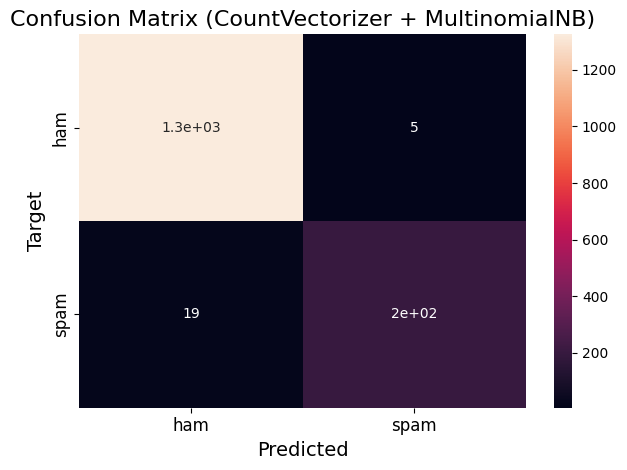

In [18]:
### 混淆矩阵测试性能
cm = confusion_matrix(y_test,MNB_test_preds,labels=MNB.classes_)
ax = sns.heatmap(cm,annot=True)
ax.set_title('Confusion Matrix (CountVectorizer + MultinomialNB)',fontsize=16)
ax.xaxis.set_ticklabels(['ham','spam'],fontsize=12) 
ax.yaxis.set_ticklabels(['ham','spam'],fontsize=12) 
ax.set_xlabel("Predicted",fontsize=14)
ax.set_ylabel("Target",fontsize=14)
plt.tight_layout()

In [19]:
prob_train = MNB.predict_proba(X_train2)[:,1]
prob_test  = MNB.predict_proba(X_test2)[:,1]
print("train AUC:",roc_auc_score(y_train,prob_train))
print("test AUC:",roc_auc_score(y_test,prob_test))

train AUC: 0.9902179311945066
test AUC: 0.9823509323133666


In [20]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train2 = encoder.fit_transform(y_train) 
y_test2  = encoder.fit_transform(y_test) 

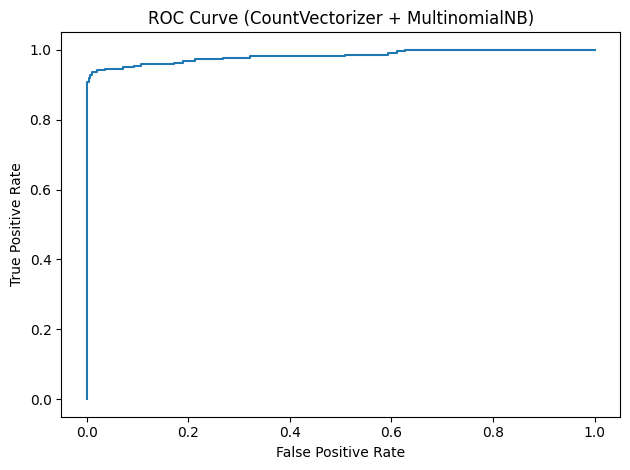

In [21]:
from sklearn.metrics import roc_curve
def plot_roc_curve(true_y,y_prob,text):
    """
    plots the roc curve based of the probabilities
    """
    fpr, tpr, thresholds = roc_curve(true_y,y_prob)
    plt.plot(fpr, tpr)
    plt.title(f'ROC Curve {text}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.tight_layout()
plot_roc_curve(y_test2,prob_test,'(CountVectorizer + MultinomialNB)')

In [22]:
### 提取TFIDF特征
featurizer = TfidfVectorizer(decode_error='ignore')
X_train3 = featurizer.fit_transform(X_train)
X_test3  = featurizer.transform(X_test)

In [23]:
MNB = MultinomialNB()
MNB.fit(X_train3,y_train)

MNB_train_preds2   = MNB.predict(X_train3)
MNB_train_results2 = get_test_scores('MNB (train)',MNB_train_preds2,y_train)

MNB_test_preds2   = MNB.predict(X_test3)
MNB_test_results2 = get_test_scores('MNB (test)',MNB_test_preds2,y_test)

MNB_results2 = pd.concat([MNB_train_results2,MNB_test_results2],axis=0)
MNB_results2

,model,precision,recall,F1,accuracy
0,MNB (train),0.979813,0.845266,0.898169,0.962963
0,MNB (test),0.971651,0.818182,0.874301,0.948420


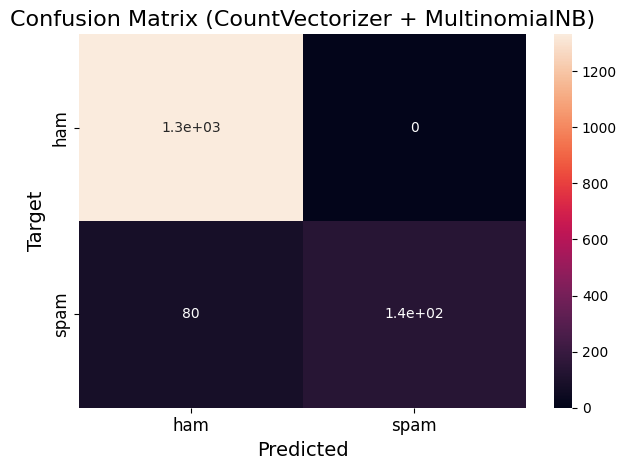

In [24]:
cm = confusion_matrix(y_test,MNB_test_preds2,labels=MNB.classes_)
ax = sns.heatmap(cm,annot=True)
ax.set_title('Confusion Matrix (CountVectorizer + MultinomialNB)',fontsize=16)
ax.xaxis.set_ticklabels(['ham','spam'],fontsize=12) 
ax.yaxis.set_ticklabels(['ham','spam'],fontsize=12) 
ax.set_xlabel("Predicted",fontsize=14)
ax.set_ylabel("Target",fontsize=14)
plt.tight_layout()

In [25]:
prob_train2 = MNB.predict_proba(X_train3)[:,1]
prob_test2  = MNB.predict_proba(X_test3)[:,1]
print("train AUC:",roc_auc_score(y_train,prob_train2))
print("test AUC:",roc_auc_score(y_test,prob_test2))

train AUC: 0.9910180878178239
test AUC: 0.9821938392186327


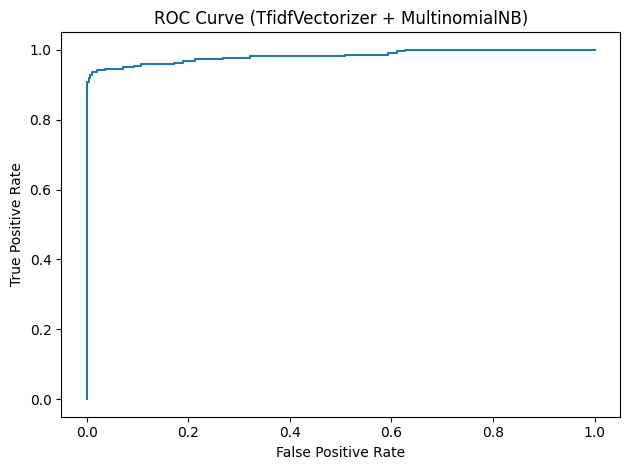

In [26]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train2 = encoder.fit_transform(y_train) 
y_test2  = encoder.fit_transform(y_test) 
plot_roc_curve(y_test2,prob_test,'(TfidfVectorizer + MultinomialNB)')